In [5]:
import os
import pandas as pd
import numpy as np
import random
import sklearn
from wordcloud import WordCloud
from sklearn import metrics
#import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.inspection import PartialDependenceDisplay
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics # Import scikit-learn metrics module for accuracy calculation
from sklearn import preprocessing # Import preprocessing for String-Int conversion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
from collections import Counter
import itertools

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kilea\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kilea\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kilea\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\kilea\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [6]:
# Load in the dictionary dataset into a pandas df
data_path = os.path.join(os.getcwd(), 'data', 'dictionary.txt')
dic = pd.read_csv(data_path, sep='|', header=None)

# ...and do the same with the sentiment_labels data
data_path = os.path.join(os.getcwd(), 'data', 'sentiment_labels.txt')
cents = pd.read_csv(data_path, sep='|')

dic = dic.rename(columns={0: "feature", 1: "ID"})# We rename the columns
# dic = dic.rename(index={range(239232)})
dic = dic.sort_values(by="ID") # We change the order of the rows to be sorted by ID number
movie_data = dic[["ID", "feature"]] # We change the order of the columns and change the name of the the df

# We make an array of the sentiments (already in the right order) and add it to our df
y = np.array(cents.iloc[:, -1])
movie_data.insert(2, "sentiment", y)

phrase_data = movie_data.sort_index()
phrase_data.drop("ID",axis=1,inplace=True)
phrase_data.insert(2,"label",0)

print(phrase_data.head())

       feature  sentiment  label
0            !    0.50000      0
1          ! '    0.52778      0
2         ! ''    0.50000      0
3       ! Alas    0.44444      0
4  ! Brilliant    0.86111      0


In [7]:
### We create a smaller subsample of the dataset - to speed up the computation when working on our code

# specify a smaller number of reviews
small_N = 2390

# choose small_N random and distinct integers between 0 and 239231
rand = random.sample(range(239231), small_N)

# find these indices in the original dictionary - and make a new array of them
rand_sample = phrase_data.iloc[rand]

rand_sample.head()

,feature,sentiment,label
120437,"giving a tight , focused performance illuminat...",0.68056,0
95466,choking sense,0.30556,0
74432,airhead movie,0.26389,0
50387,The Porky 's Revenge :,0.44444,0
214983,they succeed merrily at their noble endeavor .,0.75000,0


In [8]:
### We can use the random sample or the full data set going forward

phrases = phrase_data
# phrases = rand_sample

In [9]:
### add correct labels based on sentiment column (uses qualities of numpy for efficiency)

np_phrase = np.array(phrases) # make it a numpy array

# create a series of boolean masks
vpos = (0.8 < np_phrase[:, 1]).astype(int)
pos =  (0.6 < np_phrase[:, 1]).astype(int)
ntrl = (0.4 < np_phrase[:, 1]).astype(int)
neg = (0.2 < np_phrase[:, 1]).astype(int)
vneg = (0 <= np_phrase[:, 1]).astype(int)

# add the masks together to get the correct label numbers for each review based on sentiment value
h = vneg + neg + ntrl + pos + vpos - 1

# update the array with our new values
np_phrase[:, 2] = h

# change back to a pandas
phrases = pd.DataFrame(np_phrase)

In [10]:
# Feature importance

filler_words = set(stopwords.words('english'))
lemmatize = WordNetLemmatizer()

#values =[[0, 0.2], [0.2, 0.4], [0.4, 0.6], [0.6, 0.8], [0.8, 1.0]]
labels = ['very negative', 'negative', 'neutral', 'positive', 'very positive']
to_drop = []

phrases_list = list(phrases.iloc[:, 0])

for i in range(len(phrases_list)):
    # 'clean' phrases: remove numbers, punctuation and filler words
    phrase = phrases_list[i]
    phrase = re.sub(r'[^\w]', " ", phrase) #remove all special characters 
    cleaned = re.sub(r'[\d]', " ", phrase)  #remove all numbers

    if (cleaned.replace(" ","")==""):
        to_drop.append(i)
        cleaned=""
    else:
        cleaned = word_tokenize(cleaned.lower()) #tokenise for bag of words
        cleaned = [w for w in cleaned if w not in filler_words] # #remove all filler words
        cleaned = [lemmatize.lemmatize(word) for word in cleaned]
    
    phrases_list[i] = cleaned
    
phrases.iloc[:, 0] = phrases_list

# remove unnecessary data
phrases.drop(1,axis=1,inplace=True) 
phrases.drop(to_drop,axis=0,inplace=True)
df = phrases[~phrases.astype(str).duplicated()]
df.reset_index(inplace=True)
df.drop("index",axis=1,inplace=True)
print(df.head())
print(df.shape)

#save this as file
df.to_pickle("clean_doc.pkl", protocol=4)

                                           0  2
0                                      [ala]  2
1                                [brilliant]  4
2                                   [c, mon]  2
3          [gollum, performance, incredible]  3
4  [oh, look, clever, angle, wow, jump, cut]  1
(149902, 2)


C:\Users\kilea\anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [11]:
#Exploratory data analysis

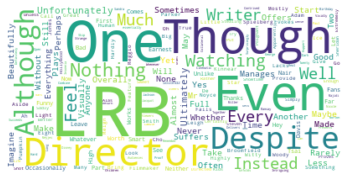

NameError: name 'perc' is not defined

In [13]:


from collections import Counter
wtext = os.path.join(os.getcwd(), 'data', 'datasetSentences.txt')
words =   pd.read_csv(wtext, sep='|', header=None)


#word cloud

#Checking for NaN values

words.isna().sum()
#Removing NaN Values this is some times needed for certain word clouds
#words.dropna(inplace = True)
#Creating the text variable
text = " ".join(cat.split()[1] for cat in words[0])
# Creating word_cloud with text as argument in .generate() method
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)
# Display the generated Word Cloud
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#percentage of words that contain although, despite, even though. inside of the movie reveiews 

keywords =('although','despite', 'though',)
words.columns = ['text']
words.columns = words.columns.str.strip()

words['perc_words'] = words.text.str.count('|'.join(keywords)) / words.text.str.split().str.len()

np_words =np.array(words)
perc = np_words[np_words[:,1] =]
print(len(words)/len(perc)) # percentage of common semantic shift words



In [ ]:
#words for each sentiment
#need to add scrub
Counter(df)

np_phrase1 = np.array(df)


bars = []

for i in range (5):
    print(i)
    Sent = np_phrase1[np_phrase1[:,1] == i]

    words1 = pd.DataFrame(Sent)
     
    words1[0] = words1[0].astype(str).str.replace('[^\w\s]', '')

    words1[0].astype(str).str.lower().str.split()
    results = set()
    words1[0].astype(str).str.lower().str.split().apply(results.update)
    results = Counter()
    words1[0].astype(str).str.lower().str.split().apply(results.update)
    
    ignore = ['movie' ,'film' , 'n','one']
    for word in list(results):
        if word in ignore:
            del results[word]


    barx =  pd.DataFrame(results.most_common(10))
    barx.columns = ['words', 'count',]
    bars.append(barx)
    #print(bar1)

    

ax0 = bars[0].plot.bar(x = 'words' , y =  'count', align='edge', width=-0.4, label='Very Negative')  
ax1 = bars[1].plot.bar(x = 'words' , y =  'count', align='edge', width=-0.4, label='Negative')
ax2 = bars[2].plot.bar(x = 'words' , y =  'count', align='edge', width=-0.4, label='Neutral')
ax3 = bars[3].plot.bar(x = 'words' , y =  'count', align='edge', width=-0.4, label='Positive')
ax4 = bars[4].plot.bar(x = 'words' , y =  'count', align='edge', width=-0.4, label='Very Positive')

#I think it is so close to putting them together but i cant


#change back to a pandas
#phrases = pd.DataFrame(np_phrase)

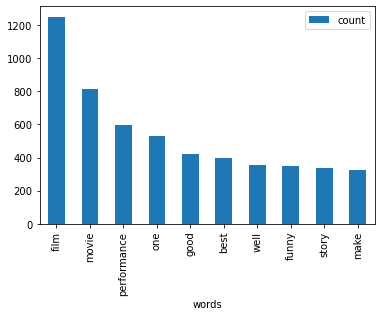

In [8]:
# I'm commenting the below out cus it takes ages to run and ive got the model and embedding saved #

In [ ]:
# ### we are going to train our embedding model on the original review corpus
# ### in the hope to capture more semantic information

# # opening the file in read mode and reading the file
# orig_snip = open("original_rt_snippets.txt")
# orig_snip = orig_snip.read()

# # spliting into separate lists for each line in the txt file
# orig_snip = orig_snip.split("\n")

# # looping over each review
# for i in range(len(orig_snip)):
    
#     orig_snip[i] = orig_snip[i].lower() # lower case
    
#     orig_snip[i] = re.sub(r'[^\w]', " ", orig_snip[i]) # remove all special characters
#     orig_snip[i] = re.sub(r'[\d]', " ", orig_snip[i]) # ...and numbers
    
#     orig_snip[i] = nltk.word_tokenize(orig_snip[i]) # make each word an individual string, thus each review is a sublist
    
#     orig_snip[i] = [word for word in orig_snip[i] if word not in stopwords.words("english")] # removing stop-words
#     orig_snip[i] = [lemmatize.lemmatize(word) for word in orig_snip[i]] # lemmatizing (converting to the grammatical root)

In [ ]:
# orig_snip_clean_edit = orig_snip.copy() # copying the data to save having to run the last chunk again

In [ ]:
# ### We are going to remove the 50 most frequent words from the corpus - this should make our embedding more accurate
# topmost = 50

# word_counts = Counter(itertools.chain.from_iterable(orig_snip_clean_edit))  # counting each word in the corpus
# words_most_freq = [k for k, v in word_counts.most_common(topmost)] # getting a list of the top 50

# for i in range(len(orig_snip_clean_edit)): # looping over each review
    
#     # Remove the most frequent words
#     orig_snip_clean_edit[i] = [word for word in orig_snip_clean_edit[i] if word not in words_most_freq]

In [ ]:
# # importing genism modules and setting up logging
# import gensim, logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# # create our model, specifying our hyperparameters
# word2vec = gensim.models.Word2Vec(orig_snip_clean_edit, epochs=3, min_count=5, window=3, vector_size=50)

# # saving the model
# word2vec.save('word2vec_model')

In [ ]:
# word2vec = gensim.models.Word2Vec.load('word2vec_model')

In [ ]:
# word2vec.wv.most_similar("disney", topn=10)

In [ ]:
 ### We clean the dictionary file as we did the original review corpus
# dicti = open("dictionary-Copy1.txt")
# dicti = dicti.read()

# dicti = dicti.split("\n")

# for i in range(len(dicti)):
    
#     dicti[i] = dicti[i].lower()
    
#     dicti[i] = re.sub(r'[^\w]', " ", dicti[i]) # remove all special characters
#     dicti[i] = re.sub(r'[\d]', " ", dicti[i]) # ...and numbers
    
#     dicti[i] = nltk.word_tokenize(dicti[i])
    
#     dicti[i] = [word for word in dicti[i] if word not in stopwords.words("english")]
#     dicti[i] = [lemmatize.lemmatize(word) for word in dicti[i]]

In [ ]:
# Looks like we have an extra row the end (no matter)

len(dicti)

In [ ]:
# ### We count the number of words in the original corpus and the dictionary and compare

# word_count_dict = Counter(itertools.chain.from_iterable(dicti))
# word_count_orig = Counter(itertools.chain.from_iterable(orig_snip))
# print(len(word_count_dict.most_common()[0:]), len(word_count_orig.most_common()[0:]))
# print(len([k for k, v in word_count_dict.most_common()[0:]]), len([k for k, v in word_count_orig.most_common()[0:]]))

In [ ]:
# ### We create a list of all the words in dictionary that arent in the original snippets corpus (270 spanish words)
# ### looks like some spanish reviews are in the dictionary and not in the snippets
# odd_words = []
# for word in [k for k, v in word_count_dict.most_common()[0:]]:
#     if word not in [k for k, v in word_count_orig.most_common()[0:]]:
#         odd_words.append(word)

In [ ]:

# ### Our word2vec model removes all words which have less than 5 appearances in the corpus (we find a list of those words)

# word_count_orig_clean_edit = Counter(itertools.chain.from_iterable(orig_snip_clean_edit))
# below_min_count = [k for k,v in word_count_orig_clean_edit.most_common() if v < 5]

In [ ]:
# ### We collate the lists of words our word2vec model doesn't have vectors for 
# ### (top 50 most frequent, below 5 counts, odd spanish words)

# for word in words_most_freq:
#     below_min_count.append(word)
    
# for word in odd_words:
#     below_min_count.append(word)
    
# bad_words = below_min_count

In [ ]:
# ### We are going to embed each dictionary sentence by summing all the vectors of the contained words

# y_values = h # specify our label vector
# X_dicti = np.zeros([len(dicti)-1, 50]) # create an empty array

# # looping over all the rows of the dictionary (apart from the empty final one)
# for i in range(len(dicti)-1):
    
#     sent_vec = 0 
    
#     for word in dicti[i]: # for each word...
        
#         if word not in bad_words: # ...if the word is contained in our word2vec model...
            
#             word_vec = word2vec.wv.get_vector(word) #... we get its vector
            
#             sent_vec += word_vec # ...and we sum them
            
#     X_dicti[i] = sent_vec

In [ ]:

# # We add the labels
# X_wlabels = np.hstack((X_dicti, np.atleast_2d(y_values).T))

In [ ]:

# # And remove empty rows (rows from which the above process removed everything)
# X_embed_wlabels = X_wlabels[~np.all(X_wlabels[:][:, :-1] == 0, axis=1)]

In [ ]:
# # We save the array, and split into X and y
# np.save('Embedding array', X_embed_wlabels, allow_pickle=True)
# X_embed = X_embed_wlabels[:][:, :-1]
# y_labels = X_embed_wlabels[:][:, -1]

In [ ]:
#split test and train

x_train, x_test, y_train, y_test = train_test_split(X_embed, y_labels, test_size=0.3, random_state=1) # 70% training and 30% test
print(x_train.shape,x_test.shape,y_train.ravel().shape)

In [ ]:
# #naive bayes
# clf = MultinomialNB()
# clf.fit(x_train,y_train)
# print(clf.score(x_train,y_train))
# print(clf.score(x_test,y_test))

In [ ]:
#above not great, maybe add in a regulariser?

#confusion matrix
matrix = confusion_matrix(y_test,clf.predict(x_test), normalize='true')

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(matrix, annot=True) 
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xlabel('predicted')
ax.set_ylabel('true')
# plt.savefig("NB_confused.png")
plt.show()

In [ ]:
# #random forest - grid search for optimal decision tree parameters -maybe try dif criterion
# rf_dic={
#     "n_estimators":[10,50,200,500],
#     "max_features": ["sqrt","log2"],
#     "criterion": ["gini"],
#     "max_depth": [4,8,30]
#     }

# rf = RandomForestClassifier(random_state=1)
# grid_search = GridSearchCV(estimator=rf,param_grid=rf_dic,cv=3)
# grid_search.fit(x_train,y_train)

# print("the best parameters are: " +str(grid_search.best_params_))

# print("accuracy: " + str(grid_search.best_estimator_.score(x_test, y_test)*100) + "%")

In [ ]:
# #confusion matrix
# matrix = confusion_matrix(y_test,grid_search.best_estimator_.predict(x_test), normalize='true')

# fig, ax = plt.subplots(figsize=(10, 10))
# sns.heatmap(matrix, annot=True) 
# ax.set_xticklabels(labels)
# ax.set_yticklabels(labels)
# ax.set_xlabel('predicted')
# ax.set_ylabel('true')
# # plt.savefig("RandForest_confused.png")
# plt.show()

In [ ]:
#log reg

clf2 = LogisticRegression()
clf2.fit(x_train,y_train)
print(clf2.score(x_train,y_train))
print(clf2.score(x_test,y_test))

matrix2 = confusion_matrix(y_test,clf2.predict(x_test), normalize='true')

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(matrix2, annot=True) 
ax.set_xticklabels([0, 1, 2, 3, 4])
ax.set_yticklabels([0, 1, 2, 3, 4])
ax.set_xlabel('predicted')
ax.set_ylabel('true')
# plt.savefig("logreg_confused.png")
plt.show()